# Подготовка данных

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
import scipy.cluster.hierarchy as sch

import seaborn as sns
import matplotlib.pyplot as plt


In [ ]:

# Загрузка данных
data = pd.read_csv('RedWineQuality.csv', sep=';')

# Выбор переменных для кластеризации
selected_features = ['volatile acidity', 'alcohol', 'sulphates', 'density']
X = data[selected_features]

# Масштабирование данных
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Подбор оптимального числа кластеров

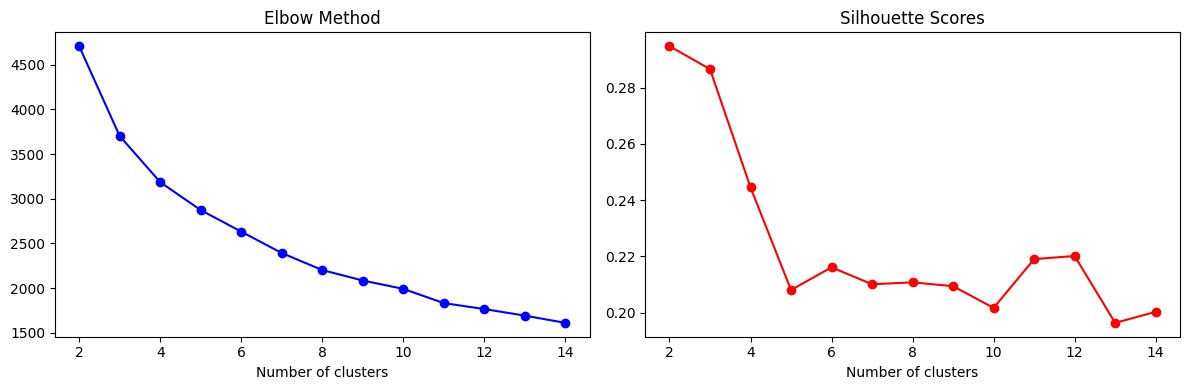

In [2]:
# Метод локтя и силуэта
wcss = []
silhouette_scores = []
k_range = range(2, 15)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))

# Визуализация
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.plot(k_range, wcss, 'bo-')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')

plt.subplot(122)
plt.plot(k_range, silhouette_scores, 'ro-')
plt.title('Silhouette Scores')
plt.xlabel('Number of clusters')
plt.tight_layout()
plt.show()

### Оптимальное число кластеров: 5-6 (пик силуэта = 0.22)

In [3]:
kmeans = KMeans(n_clusters=5, random_state=42)
data['KMeans_Cluster'] = kmeans.fit_predict(X_scaled)

# Иерархическая кластеризация

## Сравнение методов связывания

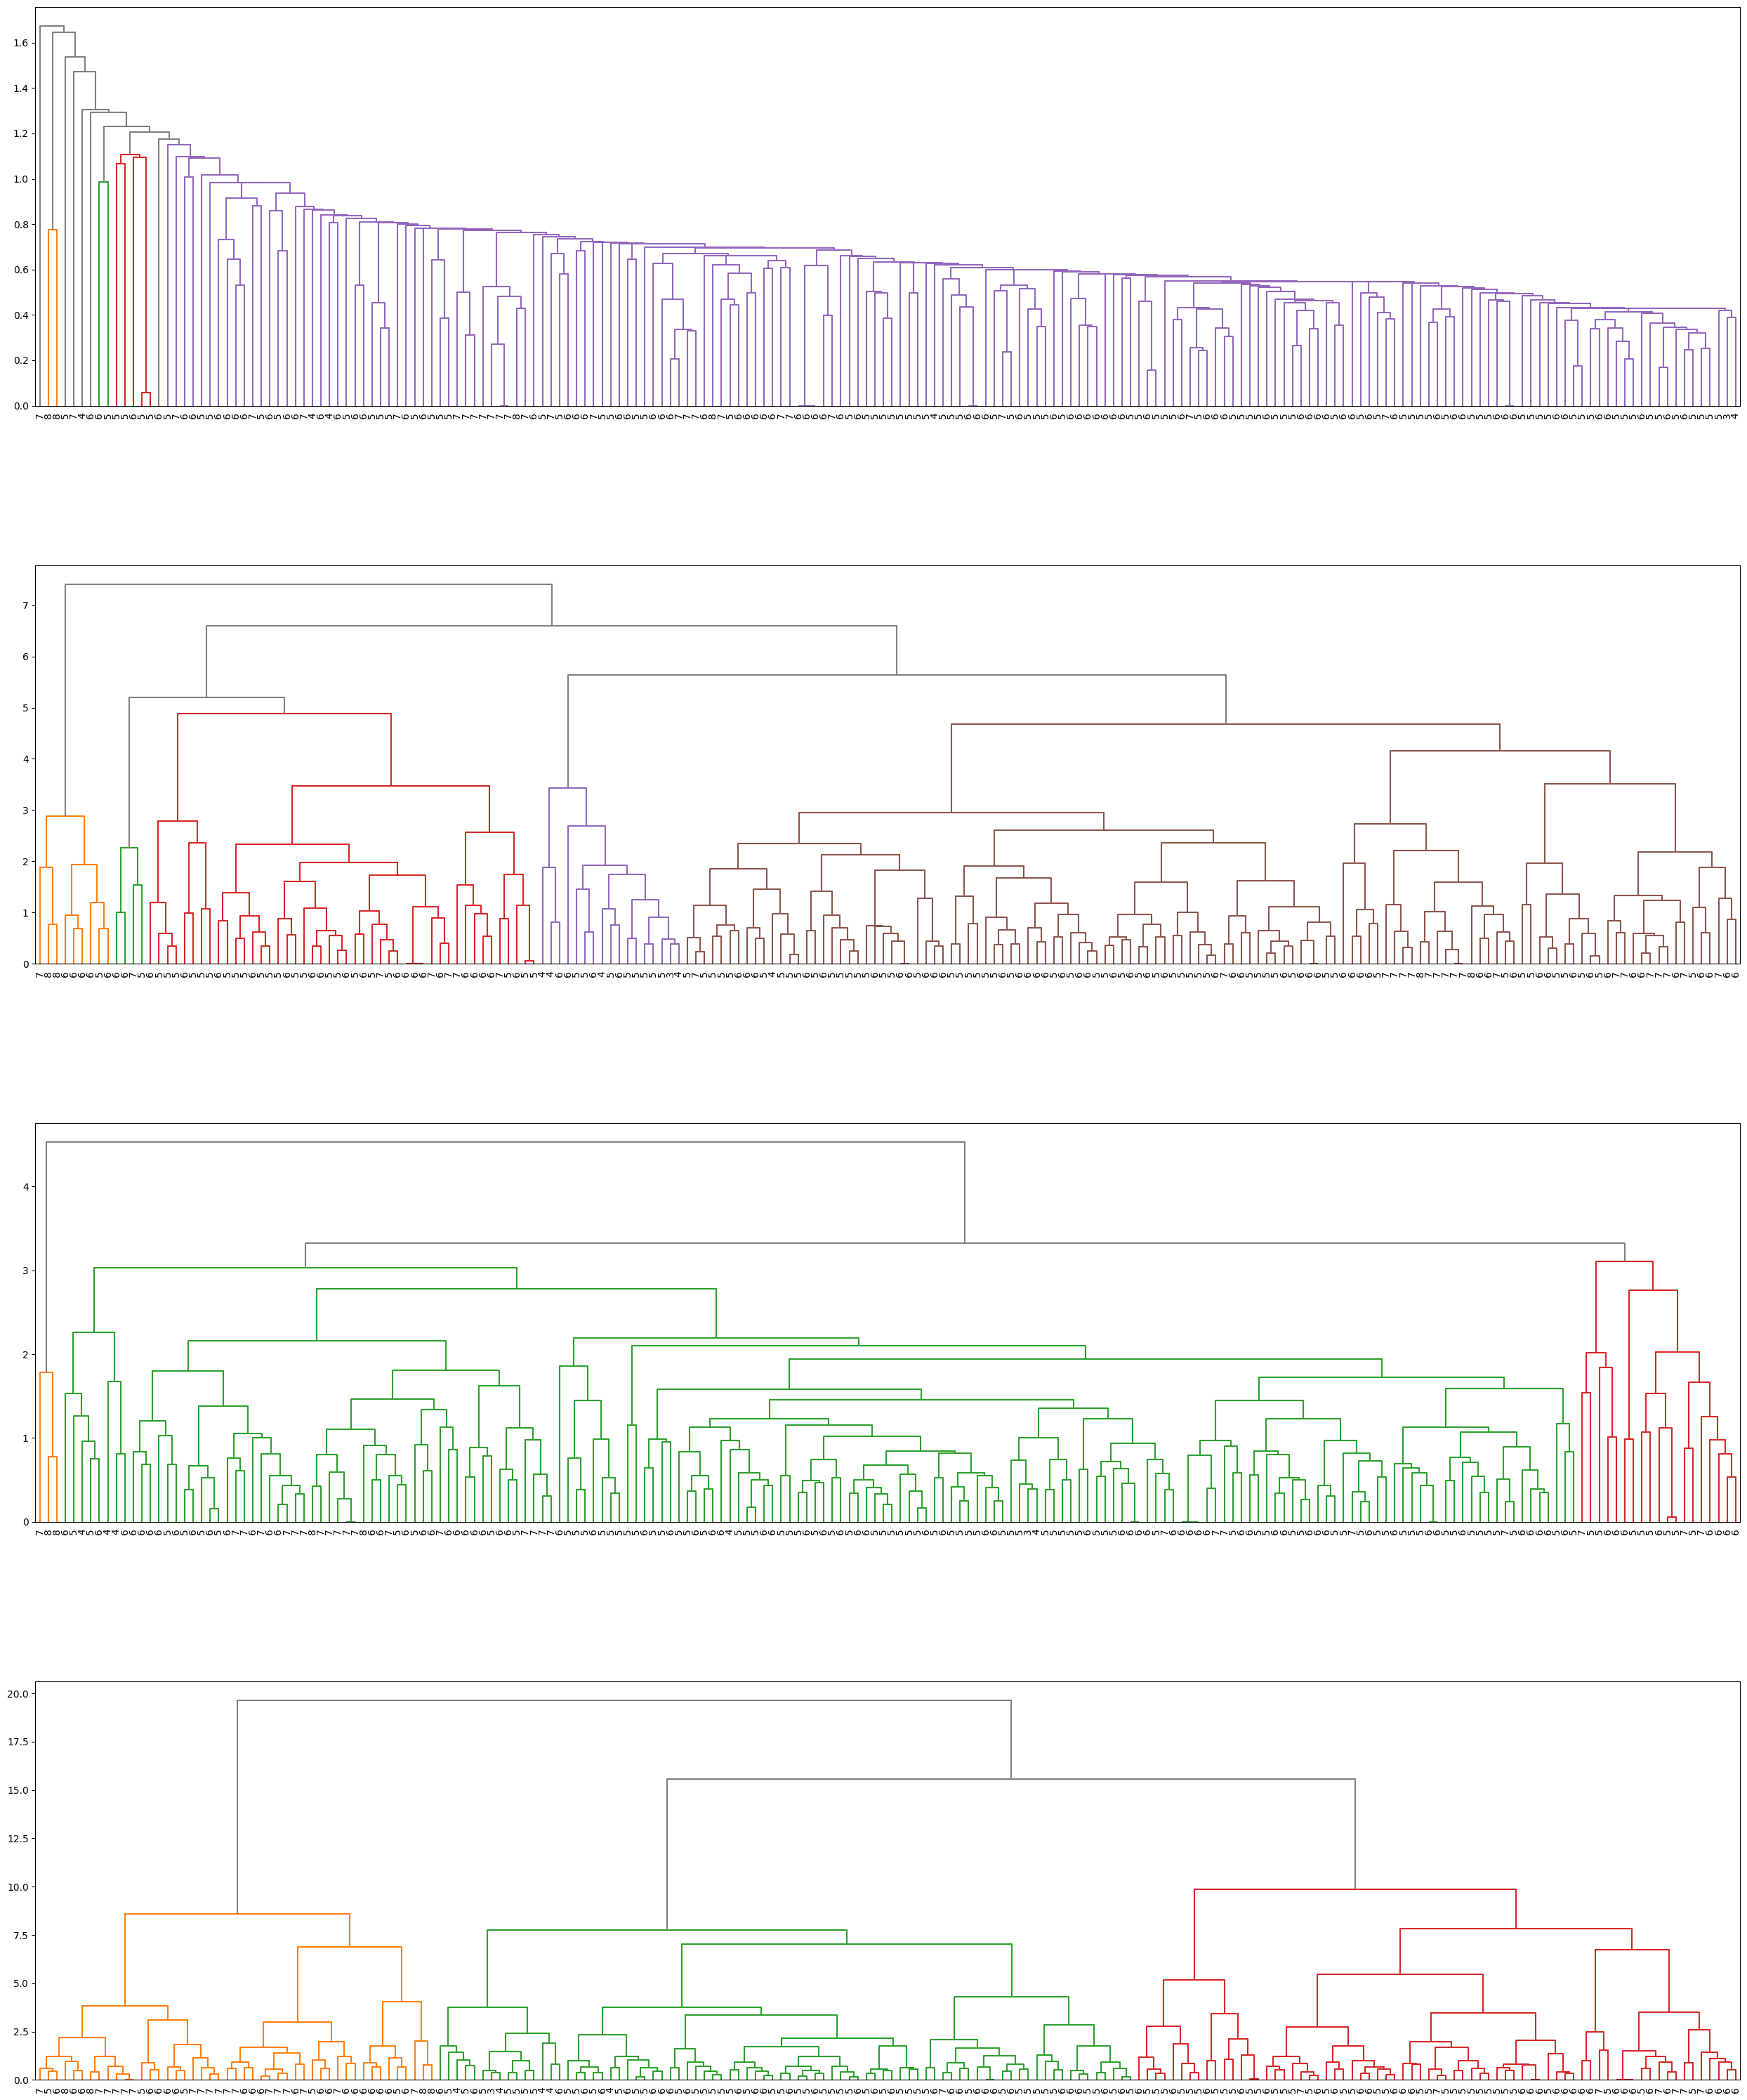

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as sch
from matplotlib import cm
from matplotlib.colors import ListedColormap

# Создаем кастомную цветовую карту для качества вина (2-8)
qualities = data['quality'].unique()
colors = cm.viridis(np.linspace(0, 1, len(qualities)))
quality_colors = {q: colors[i] for i, q in enumerate(sorted(qualities))}

# Функция для преобразования индексов в цвета качества
def get_quality_color(i):
    return quality_colors[data.iloc[i]['quality']]

# Создаем подвыборку для читаемой визуализации (300 случайных образцов)
np.random.seed(42)
sample_indices = np.random.choice(len(data), size=200, replace=False)
sample_data = data.iloc[sample_indices]
X_sample_scaled = X_scaled[sample_indices]

# Строим дендрограммы для каждого метода
methods = ['single', 'complete', 'average', 'ward']
plt.figure(figsize=(25, 30))

for i, method in enumerate(methods, 1):
    ax = plt.subplot(4, 1, i)
    
    # Вычисляем linkage матрицу
    Z = sch.linkage(X_sample_scaled, method=method)
    
    # Строим дендрограмму с цветными метками качества
    dendrogram = sch.dendrogram(
        Z,
        labels=sample_data['quality'].values,
        leaf_rotation=90,
        leaf_font_size=10,
        color_threshold=0.7*np.max(Z[:, 2]),
        above_threshold_color='gray',
        ax=ax
    )
    
    # Добавляем цветные метки для качества
    """
    for j, (quality, color) in enumerate(zip(dendrogram['ivl'], dendrogram['leaves_color_list'])):
        if color == 'gray':  # Пропускаем серые кластеры
            continue
        ax.text(j, -0.05, quality, 
                color=quality_colors[int(quality)], 
                fontsize=9, 
                ha='center', 
                va='top',
                bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=1))
    
    plt.title(f'Метод: {method.capitalize()}', fontsize=14, pad=20)
    plt.xlabel('Образцы вина с указанием качества', fontsize=12)
    plt.ylabel('Расстояние', fontsize=12)
    plt.grid(axis='y', alpha=0.3)
    """

plt.tight_layout()
plt.subplots_adjust(hspace=0.4)
plt.show()

Выводы по дендрограммам:

* Single linkage: Образует один доминирующий кластер
* Complete linkage: 5 кластеров разного размера
* Average linkage: Разделение на 1 огромный кластер, 2 небольшой и 3-й незначительного размера
* Ward: Наиболее сбалансированное разделение на 3 кластера

In [5]:
hierarchical = AgglomerativeClustering(n_clusters=5, linkage='ward')
data['Hierarchical_Cluster'] = hierarchical.fit_predict(X_scaled)

# Визуализация кластеров

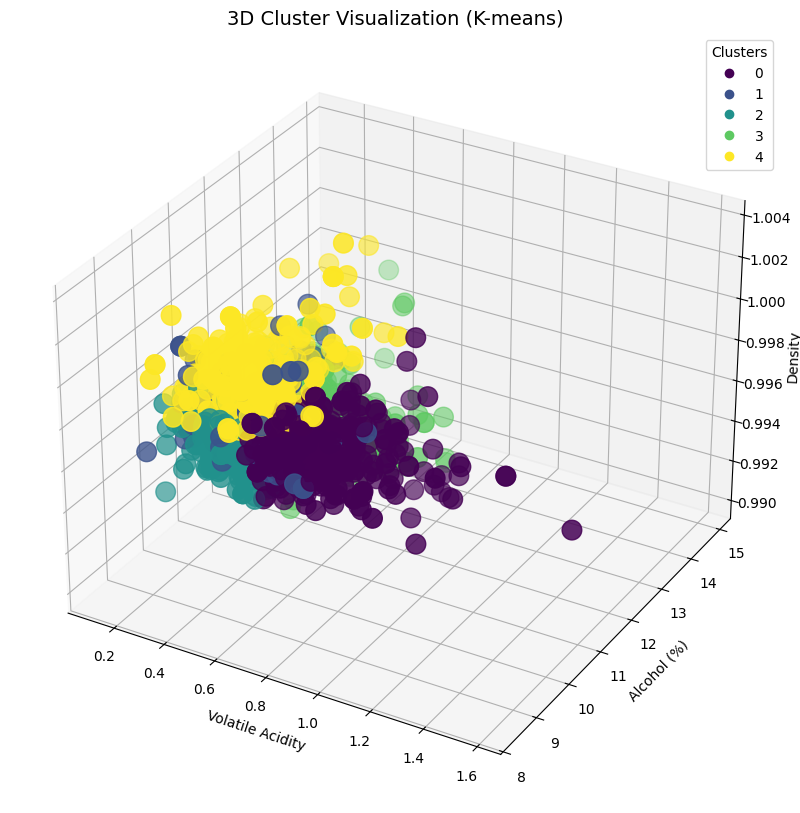

In [23]:
fig = plt.figure(figsize=(15, 10))

# 3D-визуализация
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(
    data['volatile acidity'], 
    data['alcohol'], 
    data['density'],
    c=data['KMeans_Cluster'], 
    #c=data['quality'], 
    cmap='viridis',
    s=200,
    depthshade=True
)

ax.set_xlabel('Volatile Acidity')
ax.set_ylabel('Alcohol (%)')
ax.set_zlabel('Density')
plt.title('3D Cluster Visualization (K-means)', fontsize=14)
plt.legend(*scatter.legend_elements(), title='Clusters')
plt.show()

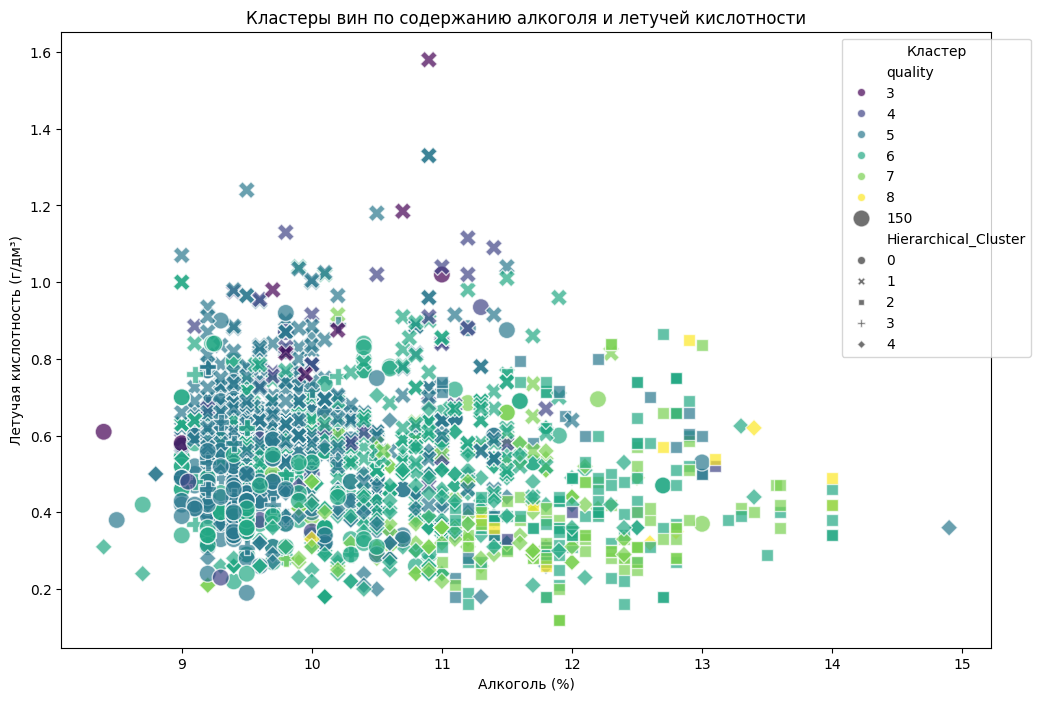

In [9]:
# Иерархическая кластеризация с оптимальными параметрами
final_model = AgglomerativeClustering(
    n_clusters=5, 
    linkage='ward',
    compute_full_tree=True
)

data['Hierarchical_Cluster'] = final_model.fit_predict(X_scaled)

# Визуализация результатов
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x='alcohol', 
    y='volatile acidity',
    style='Hierarchical_Cluster',
    hue='quality',
    #size='Hierarchical_Cluster',
    size = 150, 
    sizes=(150, 150),    
    palette='viridis',
    data=data,
    alpha=0.7
)
plt.title('Кластеры вин по содержанию алкоголя и летучей кислотности')
plt.xlabel('Алкоголь (%)')
plt.ylabel('Летучая кислотность (г/дм³)')
plt.legend(title='Кластер', bbox_to_anchor=(1.05, 1))

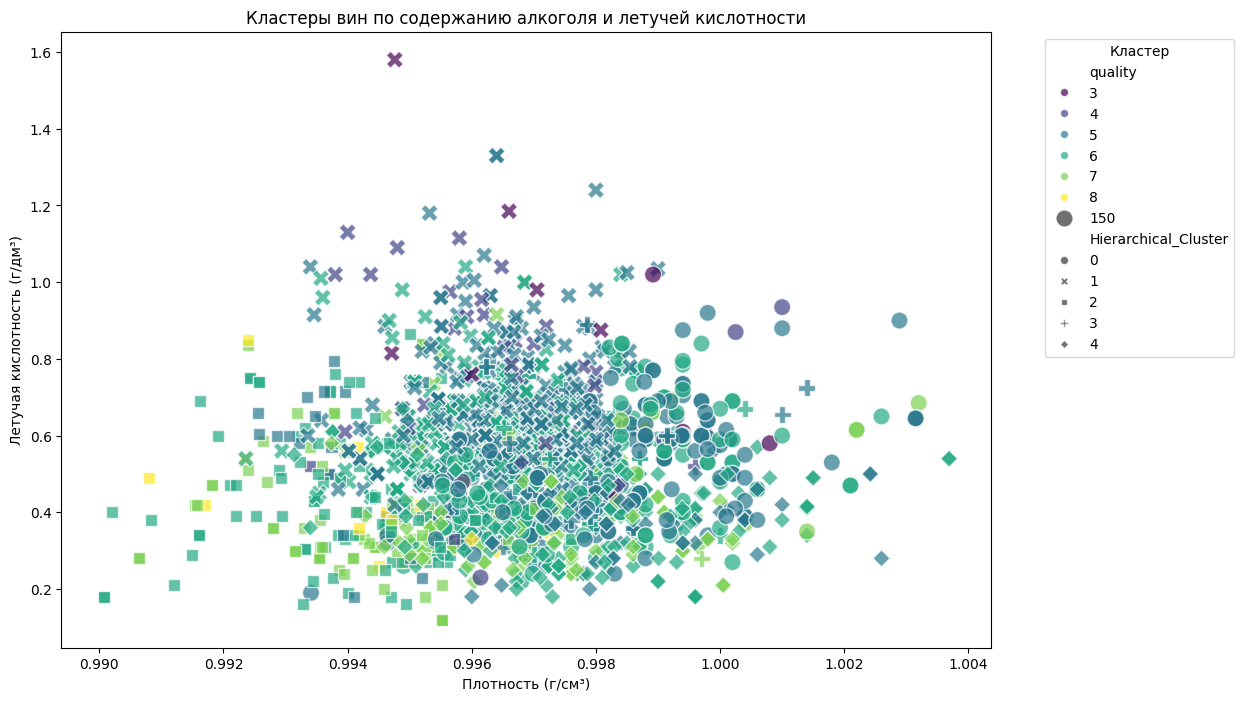

In [21]:
# Иерархическая кластеризация с оптимальными параметрами
final_model = AgglomerativeClustering(
    n_clusters=5, 
    linkage='ward',
    compute_full_tree=True
)

data['Hierarchical_Cluster'] = final_model.fit_predict(X_scaled)

# Визуализация результатов
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x='density', 
    y='volatile acidity',
    style='Hierarchical_Cluster',
    hue='quality',
    #size='Hierarchical_Cluster',
    size = 150, 
    sizes=(150, 150),    
    palette='viridis',
    data=data,
    alpha=0.7
)
plt.title('Кластеры вин по содержанию алкоголя и летучей кислотности')
plt.xlabel('Плотность (г/см³)')
plt.ylabel('Летучая кислотность (г/дм³)')
plt.legend(title='Кластер', bbox_to_anchor=(1.05, 1))

# Бизнес-интерпретация полученным кластерам

### Качественные вина имеют высокое содержании алкоголя при низкой кислотности, большинство таких вин находится во 2 и в меньшей степени в 4м кластере. Наиболее кислотые и низкокачественные вина относятся к первому кластеру соласно иерархической кластеризации, а таакже к 0-му и и 3-му кластеру.

Рекомендации для торговых сетей или HoReCa:

Кластер 2 (Премиум-сегмент):

* Улучшенные химические показатели -- низкая кислотность и плотность, высокиая крепость и преимущественно высокое качество.

Фокус на снижении летучей кислотности

Кластер 4 (Стандартный сегмент):

* Типичные параметры для средней уровня

Кластеры 0 и 1:

* Этих вин лучше избегать

Ключевые различительные признаки: летучая кислотность, содержание алкоголя и плотность.

Вывод: Кластеризация успешно отделила группы качественных и некачественных вин. Результаты согласуются с целевой переменной качества, что подтверждает практическую значимость модели для сегментации продуктового портфеля.

### Как результат соотносится с целевой переменной, использованной в задаче классификации?

Я не использовал этот массив для задачи классификации, поэтому сравнил с результатами по t-SNE.

In [ ]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
features = data.drop('quality', axis=1)
target = data['quality']

# Масштабирование данных
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Масштабирование данных
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

tsne = TSNE(n_components=2, 
                        perplexity=50,
                        learning_rate=1000,
                        n_iter=3000,
                        random_state=42,
                        init='random')
tsne_result = tsne.fit_transform(features_scaled)


Text(0, 0.5, 't-SNE 2')

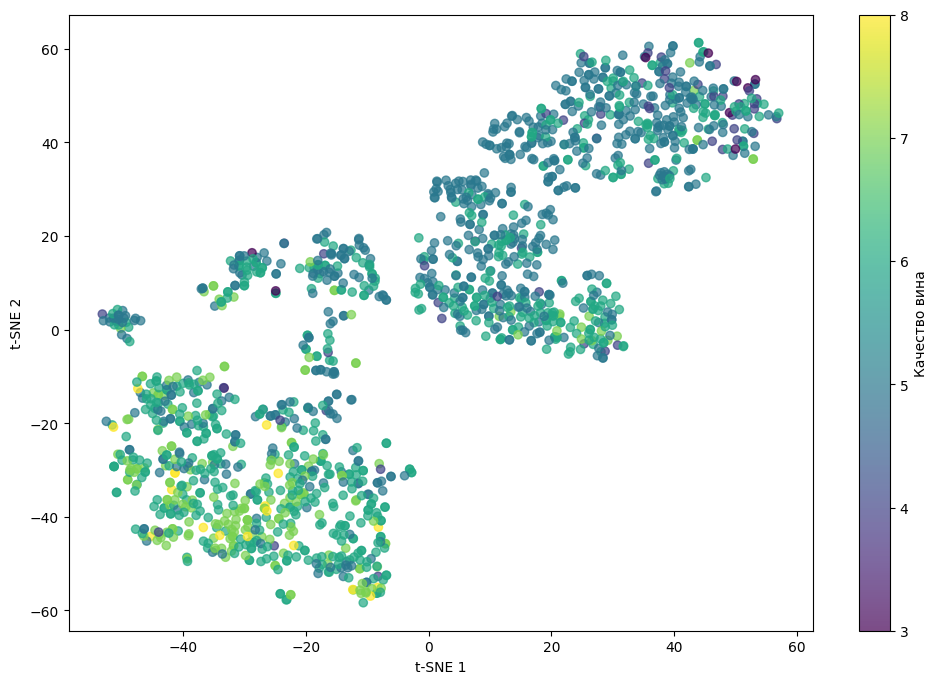

In [ ]:
# Построение графика
plt.figure(figsize=(12, 8))
scatter = plt.scatter(
    tsne_result[:, 0], tsne_result[:, 1], 
    c=target, 
    #c=data["quality"], 
    cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='Качество вина')
#plt.title(f'Perp={perp}, LR={lr}, Iter={n_iter}')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')

### t-SNE также позволил выделить 5-7 кластеров, причем один кластер с явно преобладающими качественными винами и один кластер с явно низкокачественными винами.